In [1]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)


NameError: name 'split_data' is not defined

In [4]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([wlk_fres_trace, double_support_time, fft_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-11-03 19:44:46.166400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [15]:
X_train_normalized_new = np.hstack((X_train_normalized_new[0], X_train_normalized_new[1]))
X_val_normalized_new = np.hstack((X_val_normalized_new[0], X_val_normalized_new[1]))
X_test_normalized_new = np.hstack((X_test_normalized_new[0], X_test_normalized_new[1]))

In [19]:
## Build the baseline model for emotion recognition with dropout layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, SimpleRNN, LSTM, Conv2D, Flatten, MaxPooling2D, GRU, AveragePooling2D, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
def baseline_model(inputdim):
    input_layer = Input(shape=(inputdim,))
    h = Dense(64, activation='relu')(input_layer)
    h = Dropout(0.2)(h)
    h = Dense(64, activation='relu')(h)
    h = Dense(32, activation='relu')(h)
    output_layer = Dense(2)(h)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

model = baseline_model(X_train_normalized_new.shape[1])
model_name = './checkpoints/baseline.h5'
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model.fit(x=X_train_normalized_new, y=y_train, epochs=50, batch_size=16, validation_data=(X_val_normalized_new, y_val), callbacks=[checkpoint])

Train on 29601 samples, validate on 3694 samples
Epoch 1/50


2023-11-03 19:59:12.800157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:59:12.800384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:59:12.800566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 1056/29601 [>.............................] - ETA: 27:13 - loss: 2.4847   

2023-11-03 19:59:13.015254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:59:13.015461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-03 19:59:13.015642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

29232/29601 [============================>.] - ETA: 0s - loss: 1.6065
Epoch 1: val_loss improved from inf to 1.48201, saving model to ./checkpoints/baseline.h5
29601/29601 [==============================] - 62s 2ms/sample - loss: 1.6055 - val_loss: 1.4820
Epoch 2/50
   16/29601 [..............................] - ETA: 3s - loss: 1.4923

/usr/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-11-03 19:59:14.602227: W tensorflow/c/c_api.cc:304] Operation '{name:'loss/mul' id:222 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


29056/29601 [============================>.] - ETA: 0s - loss: 1.4655
Epoch 2: val_loss improved from 1.48201 to 1.43507, saving model to ./checkpoints/baseline.h5
29601/29601 [==============================] - 2s 55us/sample - loss: 1.4653 - val_loss: 1.4351
Epoch 3/50
29360/29601 [============================>.] - ETA: 0s - loss: 1.4362
Epoch 3: val_loss improved from 1.43507 to 1.41982, saving model to ./checkpoints/baseline.h5
29601/29601 [==============================] - 2s 54us/sample - loss: 1.4364 - val_loss: 1.4198
Epoch 4/50
29008/29601 [============================>.] - ETA: 0s - loss: 1.4143
Epoch 4: val_loss did not improve from 1.41982
29601/29601 [==============================] - 2s 53us/sample - loss: 1.4148 - val_loss: 1.4201
Epoch 5/50
28624/29601 [============================>.] - ETA: 0s - loss: 1.4022
Epoch 5: val_loss improved from 1.41982 to 1.40743, saving model to ./checkpoints/baseline.h5
29601/29601 [==============================] - 2s 54us/sample - loss: 

In [23]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/baseline.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-03 20:03:42.991205: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_6_3/kernel/Assign' id:1296 op device:{requested: '', assigned: ''} def:{{{node dense_6_3/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_6_3/kernel, dense_6_3/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-03 20:03:43.089214: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_5_3/bias/v/Assign' id:1473 op device:{requested: '', assigned: ''} def:{{{node dense_5_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_5_3/bias/v, dense_5_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and 

Test MAE:
1.329998314808461
1.2552922039741838


2023-11-03 20:03:43.206640: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_7_3/BiasAdd' id:1327 op device:{requested: '', assigned: ''} def:{{{node dense_7_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_7_3/MatMul, dense_7_3/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


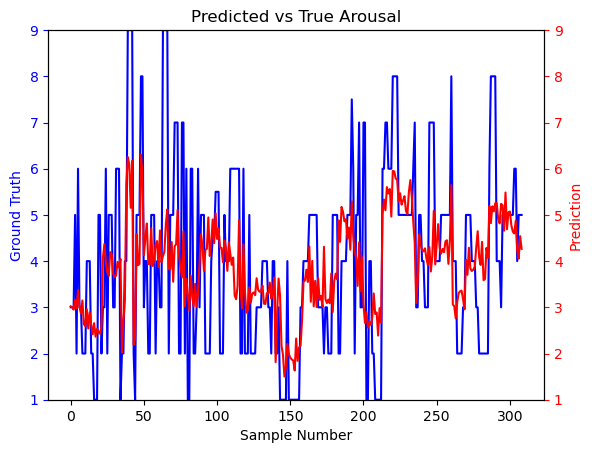

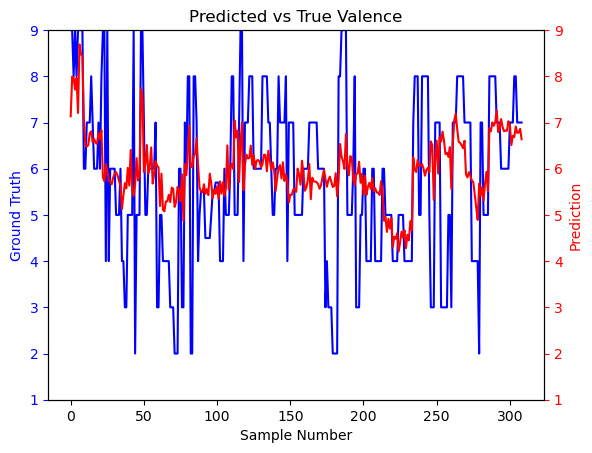

In [26]:
# Create the figure and axis
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

# Plot y1 vs x with a blue color on ax1
ax1.plot(gt_trace[:,1], 'b-', label='ground truth')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Ground Truth', color='blue')
ax1.tick_params('y', colors='blue')
plt.ylim([1,9])
# Create the second axis object
ax2 = ax1.twinx()
ax2.plot(pred_trace[:,1], 'r-', label='y2')
ax2.set_ylabel('Prediction', color='red')
ax2.tick_params('y', colors='red')

# Set a title
plt.title('Predicted vs True Arousal')
plt.ylim([1,9])
# Show the plot
plt.show()

fig, ax1 = plt.subplots()

# Plot y1 vs x with a blue color on ax1
ax1.plot(gt_trace[:,0], 'b-', label='ground truth')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Ground Truth', color='blue')
ax1.tick_params('y', colors='blue')
plt.ylim([1,9])
# Create the second axis object
ax2 = ax1.twinx()
ax2.plot(pred_trace[:,0], 'r-', label='y2')
ax2.set_ylabel('Prediction', color='red')
ax2.tick_params('y', colors='red')

# Set a title
plt.title('Predicted vs True Valence')
plt.ylim([1,9])
# Show the plot
plt.show()